# 1. VERİ OKUMA

In [72]:
import pandas as pd
import researchpy as rp
import re
import numpy as np
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

#####################################################################################################
########################## VERİ OKUMA ###############################################################
print("VERİ OKUMA")
data_csv = pd.read_csv("data/distance_learning_tweets_100k.csv")
df = data_csv.copy() 
#df = data_csv.copy() [:4000]

df_list = df['Tweets'].values.tolist()
df['Tweets'] = pd.DataFrame(df_list)
print("VERİ OKUMA BİTTİ")

VERİ OKUMA
VERİ OKUMA BİTTİ


In [73]:
df

,Tweets
0,1357048805078794240 2021-02-03 22:30:22 +0300 ...
1,1357047758457290753 2021-02-03 22:26:13 +0300 ...
2,1357046304602546177 2021-02-03 22:20:26 +0300 ...
3,1357045817375248384 2021-02-03 22:18:30 +0300 ...
4,1357045182924005378 2021-02-03 22:15:58 +0300 ...
...,...
99994,1324730409243103233 2020-11-06 18:08:36 +0300 ...
99995,1324730331308675074 2020-11-06 18:08:17 +0300 ...
99996,1324729616527986688 2020-11-06 18:05:27 +0300 ...
99997,1324729115539345409 2020-11-06 18:03:28 +0300 ...


# 2. VERİ ÖN İŞLEME

# 2.1 VERİ TEMİZLEME

In [74]:
#####################################################################################################
########################## VERİ TEMİZLEME ###########################################################
print("VERİ TEMİZLEME")

# buyuk-kucuk donusumu
df['Tweets'] = df['Tweets'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
#print(df)

# sayısal verilerin temizliği
df['Tweets'] = df['Tweets'].str.replace('\d', '')
#print(df)

match_hashtag = r'^#'
df['Tweets'] = df['Tweets'].apply(lambda x: " ".join(x for x in x.split() if not re.match(match_hashtag, x)))

match_etiketleme = r'^@'
df['Tweets'] = df['Tweets'].apply(lambda x: " ".join(x for x in x.split() if not re.match(match_etiketleme, x)))

match_uzanti = r'^https'
df['Tweets'] = df['Tweets'].apply(lambda x: " ".join(x for x in x.split() if not re.match(match_uzanti, x)))

match_kullanici = r'^<'
df['Tweets'] = df['Tweets'].apply(lambda x: " ".join(x for x in x.split() if not re.match(match_kullanici, x)))

# ingiliz alfabesinde olmayan karakterlerin temizlenmesi
df['Tweets'] = df['Tweets'].apply(lambda x: " ".join(x for x in x.split() if x.isascii()))

# noktalama işaretleri
df['Tweets'] = df['Tweets'].str.replace('[^\w\s]', '')
df['Tweets'] = df['Tweets'].str.replace('rt', '')

# stopwords
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')
# df['Tweets'] = df['Tweets'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
# print(df)

# stopwords
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

sw = stopwords.words('english')
duygulu_kelimeler = {'not', 'none', 'nan', 'nt',
                    'dosen','dosent', 'dosenot',
                    'donot', 'dont',
                    'didnt', 'didnot', 'didn', 'didnot',
                    'couldn', 'couldnt', 'couldnot', 'cannot', 'cant', 'cannt',
                    'wouldnot', 'wouldnt', 'wont', 'wouldn',
                    'mustn', 'mustnt', 'mustnot',
                    'mightn', 'mightnt',  'mightnot',
                    'needn', 'neednt','neednot',
                    'isn','isnt', 'isnot',
                    'aren','arent', 'arenot',
                    'weren','werent', 'werenot',
                    'haven', 'havent', 'havenot',
                    'shouldnot', 'shouldnt', 'shouldn', 'shan', 'shant',
                    'hasn', 'hasnt', 'hasnot'}

sw_new = []
for engellenecek_kelime in sw:
    if engellenecek_kelime not in duygulu_kelimeler:
        sw_new.append(engellenecek_kelime)

df['Tweets'] = df['Tweets'].apply(lambda x: " ".join(x for x in x.split() if x not in sw_new))
#print(df)

# lemmi ile kelime köküne indirgeme
from textblob import Word

# nltk.download('wordnet')
df['Tweets'] = df['Tweets'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# ingilizce dışında yazılan yorumları stopwordsler ile yakalama

def get_sil_list(silinecek_kelime, process_df):
    cumleler = process_df.values.tolist()
    sil_list = []
    for cumle in cumleler:
        for kelime in str(cumle).split():
            #print(kelime)
            if kelime == silinecek_kelime:
                sil_list.append(cumle)
    return sil_list

def sil_cumle(process_df, key):
    sil_index_list = []
    for silinecek in get_sil_list(key, df_tw):
        if(df_tw[(df_tw == silinecek).any(axis=1)].index[0] not in sil_index_list):
            sil_index_list.append(df_tw[(df_tw == silinecek).any(axis=1)].index[0])
    #print(sil_index_list)
    return sil_index_list


silinecek_kelime_listesi = ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de',
                            'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la',
                            'le', 'le', 'le', 'le', 'le', 'le', 'le', 'le', 'le', 'le', 'le', 'le', 'le', 'le', 'le', 'le',
                            'da', 'da', 'da', 'da', 'da', 'da', 'da', 'da', 'da', 'da', 'da', 'da', 'da', 'da', 'da',                            'da',
                            'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en',                             'en',
                            'el', 'el', 'el', 'el', 'el', 'el', 'el', 'el', 'el', 'el', 'el', 'el', 'el', 'el', 'el',                            'el',
                            'di', 'di', 'di', 'di', 'di', 'di', 'di', 'di', 'di', 'di', 'di', 'di', 'di', 'di', 'di',                            'di',
                            'et', 'et', 'et', 'et', 'et', 'et', 'et', 'et', 'et', 'et', 'et', 'et', 'et', 'et', 'et',
                           'amp', 'amp', 'amp', 'amp', 'amp', 'amp', 'amp', 'amp', 'amp', 'amp', 'amp', 'amp',
                           'pa', 'pa', 'pa', 'pa', 'pa', 'pa', 'pa', 'pa', 'pa', 'pa', 'pa', 'pa', 'pa', 'pa',
                           'u', 'u', 'u',
                             'bn', 'bn', 'bn', 'bn', 'bn', 'bn', 'bn', 'bn', 'bn',
                           'ak', 'ak', 'ak', 'ak', 'ak', 'ak', 'ak', 'ak', 'ak', 'ak', 'ak', 'ak', 'ak', 'ak']

for kelime in silinecek_kelime_listesi:
    df_tw = pd.DataFrame(df['Tweets'])
    indexList = sil_cumle(df_tw, kelime)
    df = df.drop(indexList)

print('VERİ TEMİZLEME BİTTİ')

VERİ TEMİZLEME
VERİ TEMİZLEME BİTTİ


In [80]:
df = df.dropna()
df = df.reset_index()

In [81]:
df

,index,Tweets
0,2,elearning erlaubt
1,4,training space impoant professional working fa...
2,7,made first internet dollar year half ago conve...
3,9,anaesthesia elearning programme elearning sess...
4,11,look like interesting course format sell im as...
...,...,...
75037,99994,student take elearning bark
75038,99995,xiaomi launch affordable mi notebook elearning...
75039,99996,want free place globally recognised safety hea...
75040,99997,social distancing requirement caused people sp...


# 2.2 KELİME BULUTU

KELİME BULUTU


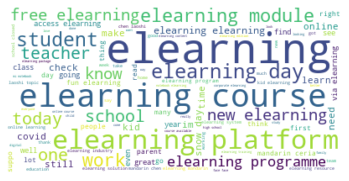

In [79]:
#####################################################################################################
########################## KELİME BULUTU ############################################################
print("KELİME BULUTU")
# Kelime Bulut Oluşturma
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

data_list = df["Tweets"].to_list()

text = " ".join(i for i in data_list)

wordCloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color = "white").generate(text)
plt.figure()
plt.imshow(wordCloud, interpolation= "bilinear")
plt.axis("off")
plt.show()


# 2.3 VEKTÖRLEŞTİRME

In [82]:
####################################################################################################
######################### VEKTÖRLEŞTİRME ###########################################################

print("VEKTÖRLEŞTİRME")

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, stop_words= sw)

tfidf_matrix = vectorizer.fit_transform(df['Tweets'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns= vectorizer.get_feature_names())

kelime_frekans = pd.DataFrame(tfidf_matrix.sum(axis=0).T,index=vectorizer.get_feature_names(),columns=['kelime frekansları'])

kelime_frekans.sort_values(by='kelime frekansları',ascending=False, inplace=True)

# İlk 20liği gösterme
print(kelime_frekans.head(20))


VEKTÖRLEŞTİRME
           kelime frekansları
elearning         6639.161320
course            1538.270297
school            1234.108718
day               1119.699739
student           1032.218218
learning           964.441416
online             910.209879
platform           868.510985
new                840.374784
free               733.253541
training           731.237698
get                727.018072
via                688.901685
today              678.979769
kid                636.712088
work               631.583660
time               626.266342
education          624.128548
help               565.752939
need               563.294383


# 2.4 DUYGU SINIFI OLUŞTURMA

In [83]:
#####################################################################################################
########################## DUYGU SINIFI OLUŞTURMA ###################################################
print("DUYGU SINIFI OLUŞTURMA")

from textblob import TextBlob

# Add polarities and subkectivities into the DataFrame by using TextBlob
df["Polarity"] = df['Tweets'].apply(lambda word: TextBlob(word).sentiment.polarity)
df["Subjectivity"] = df['Tweets'].apply(lambda word: TextBlob(word).sentiment.subjectivity)

# Display the Polarity and Subjectivity columns
print(df[["Polarity","Subjectivity","Tweets"]].head(10))

# Polarite Analizi
def duygu_sinifi_bul(polarity):
    if polarity > 0:
        return "Pozitif"
    elif polarity == 0:
        return "Notr"
    else:
        return "Negatif"

df["Duygu_Sinifi"] = df["Polarity"].apply(duygu_sinifi_bul)
print(df[["Duygu_Sinifi"]].head(10))

#####################################################################################################
########################## DUYGU SINIFI ENCODING ####################################################
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["Duygu_Sinifi_enc"] = le.fit_transform(df["Duygu_Sinifi"])

print(df["Duygu_Sinifi_enc"].head(10))


DUYGU SINIFI OLUŞTURMA
   Polarity  Subjectivity                                             Tweets
0  0.000000      0.000000                                  elearning erlaubt
1  0.100000      0.200000  training space impoant professional working fa...
2 -0.014881      0.297619  made first internet dollar year half ago conve...
3  0.400000      0.575000  anaesthesia elearning programme elearning sess...
4  0.413333      0.580000  look like interesting course format sell im as...
5  0.053333      0.346667  mutualgain developed elearning system enable p...
6  0.000000      0.100000  k student attend chicago area catholic school ...
7  0.500000      0.500000  hope masterclass went ok today watch facebook ...
8  0.016667      0.666667  dont use sharepoint generally detest google ui...
9  0.159091      0.430303  inspired new free elearning platform developed...
  Duygu_Sinifi
0         Notr
1      Pozitif
2      Negatif
3      Pozitif
4      Pozitif
5      Pozitif
6         Notr
7      Poz

# 2.4 DUYGU SINIFI GÖRSELLEŞTİRME

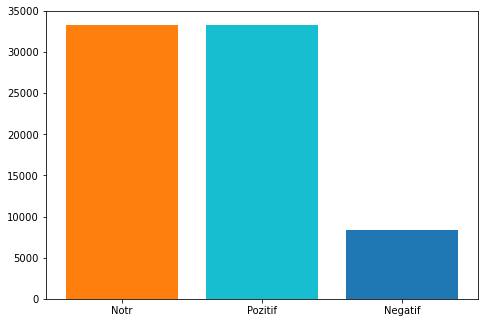

In [84]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
notr_count = 0
positive_count = 0
negative_count = 0
for duygu in df["Duygu_Sinifi"]:
    if  duygu == "Notr":
        notr_count +=1
        ax.bar('Notr', notr_count)
    elif duygu == "Pozitif":
        positive_count +=1
        ax.bar('Pozitif', positive_count)
    elif duygu == "Negatif":
        negative_count+=1
        ax.bar('Negatif', negative_count)
    
plt.show()

In [88]:
# Temiz Veriyi yeni csv olarak kaydetme
df.to_csv(path_or_buf="./data/Filtered_Tweet_Data.csv")

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75042 entries, 0 to 75041
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             75042 non-null  int64  
 1   Tweets            75042 non-null  object 
 2   Polarity          75042 non-null  float64
 3   Subjectivity      75042 non-null  float64
 4   Duygu_Sinifi      75042 non-null  object 
 5   Duygu_Sinifi_enc  75042 non-null  int32  
dtypes: float64(2), int32(1), int64(1), object(2)
memory usage: 3.1+ MB


In [90]:
df

,index,Tweets,Polarity,Subjectivity,Duygu_Sinifi,Duygu_Sinifi_enc
0,2,elearning erlaubt,0.000000,0.000000,Notr,1
1,4,training space impoant professional working fa...,0.100000,0.200000,Pozitif,2
2,7,made first internet dollar year half ago conve...,-0.014881,0.297619,Negatif,0
3,9,anaesthesia elearning programme elearning sess...,0.400000,0.575000,Pozitif,2
4,11,look like interesting course format sell im as...,0.413333,0.580000,Pozitif,2
...,...,...,...,...,...,...
75037,99994,student take elearning bark,0.000000,0.000000,Notr,1
75038,99995,xiaomi launch affordable mi notebook elearning...,0.000000,0.000000,Notr,1
75039,99996,want free place globally recognised safety hea...,0.200000,0.400000,Pozitif,2
75040,99997,social distancing requirement caused people sp...,-0.016667,0.316667,Negatif,0


# 3 EĞİTİM VERİ SETİ OLUŞTURMA

In [230]:
#####################################################################################################
########################## EĞİTİM VERİ SETİ OLUŞTURMA ###############################################
print("EĞİTİM VERİ SETİ OLUŞTURMA")

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import Layer
from tensorflow.python.keras.layers import Dense, GRU, Embedding, CuDNNGRU, Dropout
#from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences


EĞİTİM VERİ SETİ OLUŞTURMA


# 3.1 EĞİTİM VE TEST VERİ SETİ OLUŞTURMA

In [258]:
sentences = df['Tweets'].values
labels = df['Duygu_Sinifi_enc'].values

# %70 eğitim, %30 test
train_data, test_data, y_train, y_test = train_test_split( sentences, labels, test_size=0.3, random_state=1000) 

print("Train set and train labels:", train_data.shape, y_train.shape)
print("Test set and test labels:", test_data.shape, y_test.shape)


Train set and train labels: (52529,) (52529,)
Test set and test labels: (22513,) (22513,)


In [259]:
sentences

array(['elearning erlaubt',
       'training space impoant professional working family access elearning module developed phe elfh',
       'made first internet dollar year half ago conventional vpn business however finding sale channel constant struggle government unmentioned nation trying repeat trick spaced repetition based elearning platfrom',
       ...,
       'want free place globally recognised safety health elearning qualification enter competition november kicksta career tampcs',
       'social distancing requirement caused people spend time online ever rapidly accelerated ecommerce elearning remote working learn maximize digital presence reach potential customer',
       'example tab menu navigation elearning'], dtype=object)

# 3.2 CORPUS OLUŞTURMA

In [260]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

train_all_data=list()

# corpus oluşturma
for line in sentences:
	tokens=word_tokenize(line)
	token=[w.lower() for w in tokens]
	table=str.maketrans("","",string.punctuation)
	stripped = [w.translate(table) for w in tokens]
	words=[word for word in stripped if word.isalpha()]
	train_all_data.append(words)

train_all_data[1]

['training',
 'space',
 'impoant',
 'professional',
 'working',
 'family',
 'access',
 'elearning',
 'module',
 'developed',
 'phe',
 'elfh']

# 3.3 VEKTÖRLEŞTİRME

In [261]:
import gensim

embedding_dim = 60
model=gensim.models.Word2Vec(sentences=train_all_data, vector_size=embedding_dim, window=5, workers=4, min_count=1)
words=len(model.wv)
print('Vocabulary size: %d' %(words))


Vocabulary size: 39145


In [262]:
model.wv.most_similar('learning')

[('teaching', 0.8134855628013611),
 ('learner', 0.7997739315032959),
 ('reality', 0.7466048002243042),
 ('focus', 0.73836350440979),
 ('rejuvinating', 0.7168959379196167),
 ('degree', 0.7141827344894409),
 ('activity', 0.7122573852539062),
 ('planning', 0.7095257043838501),
 ('delivery', 0.7095182538032532),
 ('classroom', 0.7070638537406921)]

In [263]:
filename='embedding_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

# 3.4 EMBEDDİNG

In [264]:
import os
import numpy as np

embeddings_index={}
f = open(os.path.join('','embedding_word2vec.txt'), encoding="utf-8")

for line in f:
	values=line.split()
	word=values[0]
	coefs=np.asarray(values[1:])
	embeddings_index[word]=coefs
f.close()

# 3.5 TOKENLEŞTİRME

In [265]:
# Tokenleştirme
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data)

X_train = tokenizer.texts_to_sequences(train_data)
X_test = tokenizer.texts_to_sequences(test_data)

word_index=tokenizer.word_index
print("Unique tokens:%d" %len(word_index))

print(train_data[0])
print(X_train[0])

Unique tokens:35980
custom elearning service swift elearning solution
[1175, 1, 95, 2552, 1, 71]


In [266]:
tokenizer.word_index

{'elearning': 1,
 'course': 2,
 'school': 3,
 'day': 4,
 'student': 5,
 'learning': 6,
 'online': 7,
 'new': 8,
 'not': 9,
 'platform': 10,
 'get': 11,
 'training': 12,
 'free': 13,
 'time': 14,
 'today': 15,
 'work': 16,
 'kid': 17,
 'education': 18,
 'help': 19,
 'need': 20,
 'teacher': 21,
 'learn': 22,
 'access': 23,
 'one': 24,
 'via': 25,
 'year': 26,
 'covid': 27,
 'module': 28,
 'child': 29,
 'home': 30,
 'like': 31,
 'available': 32,
 'suppo': 33,
 'resource': 34,
 'make': 35,
 'know': 36,
 'week': 37,
 'find': 38,
 'class': 39,
 'programme': 40,
 'video': 41,
 'business': 42,
 'check': 43,
 'take': 44,
 'health': 45,
 'system': 46,
 'skill': 47,
 'back': 48,
 'also': 49,
 'use': 50,
 'offer': 51,
 'want': 52,
 'please': 53,
 'im': 54,
 'good': 55,
 'working': 56,
 'go': 57,
 'pandemic': 58,
 'de': 59,
 'people': 60,
 'website': 61,
 'see': 62,
 'way': 63,
 'great': 64,
 'would': 65,
 'content': 66,
 'program': 67,
 'first': 68,
 'th': 69,
 'best': 70,
 'solution': 71,
 'digit

In [267]:
# Tokenleştirme Analizi
def tokenization_tweets(x_data, features):
    tokenization = TfidfVectorizer(max_features=features)
    tokenization.fit(x_data)
    x_token = tokenization.transform(x_data).toarray()
    return x_token

# 3.6 GİRDİ BOYU EŞİTLEME

In [268]:
# maxlen'e göre kelime uzunluklarını eşitlemek için 0 ile doldurulmalı
from keras.preprocessing.sequence import pad_sequences

maxlen=max([len(x) for x in X_train])
print("Maxlen:", maxlen)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print("Training data:", X_train.shape)
print("Test data:", X_test.shape)


Maxlen: 52
Training data: (52529, 52)
Test data: (22513, 52)


In [269]:
# Kelime vektörleri

num_words = len(word_index) + 1
embedding_matrix= np.zeros((num_words,embedding_dim))

for word, i in word_index.items():
	if i>num_words:
		continue
	embedding_vector=embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

print(num_words)

35981


# 4. SIRALI MODEL OLUŞTURMA

In [243]:
################################################################
# Sıralı model oluşturma Embedding Layer için
from keras.models import Sequential
from keras.layers import *
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

model=Sequential()
model.add(Embedding(num_words, embedding_dim, embeddings_initializer=Constant(embedding_matrix), input_length=maxlen, trainable=False))
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 52, 60)            2158860   
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 60)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 10)                610       
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 11        
Total params: 2,159,481
Trainable params: 621
Non-trainable params: 2,158,860
_________________________________________________________________


In [244]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [245]:
model_history=model.fit(X_train ,y_train, epochs=10,  validation_data=(X_test, y_test))

Epoch 1/10
1642/1642 [==============================] - 9s 3ms/step - loss: -136.0348 - accuracy: 0.4457 - val_loss: -1202.3176 - val_accuracy: 0.4460
Epoch 2/10
1642/1642 [==============================] - 4s 3ms/step - loss: -1862.5573 - accuracy: 0.4437 - val_loss: -4302.1021 - val_accuracy: 0.4460
Epoch 3/10
1642/1642 [==============================] - 4s 3ms/step - loss: -5193.1346 - accuracy: 0.4456 - val_loss: -8769.0430 - val_accuracy: 0.4460
Epoch 4/10
1642/1642 [==============================] - 4s 3ms/step - loss: -9937.9343 - accuracy: 0.4454 - val_loss: -14454.8750 - val_accuracy: 0.4460
Epoch 5/10
1642/1642 [==============================] - 5s 3ms/step - loss: -16044.1082 - accuracy: 0.4413 - val_loss: -21268.2344 - val_accuracy: 0.4460
Epoch 6/10
1642/1642 [==============================] - 4s 3ms/step - loss: -23077.4842 - accuracy: 0.4419 - val_loss: -29203.7539 - val_accuracy: 0.4460
Epoch 7/10
1642/1642 [==============================] - 4s 3ms/step - loss: -31002.5

In [213]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [214]:
model_history=model.fit(X_train ,y_train, epochs=10,  validation_data=(X_test, y_test))

Epoch 1/10
1642/1642 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.4410 - val_loss: 0.0000e+00 - val_accuracy: 0.4460
Epoch 2/10
1642/1642 [==============================] - 4s 3ms/step - loss: 0.0000e+00 - accuracy: 0.4443 - val_loss: 0.0000e+00 - val_accuracy: 0.4460
Epoch 3/10
1642/1642 [==============================] - 4s 3ms/step - loss: 0.0000e+00 - accuracy: 0.4439 - val_loss: 0.0000e+00 - val_accuracy: 0.4460
Epoch 4/10
1642/1642 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - accuracy: 0.4409 - val_loss: 0.0000e+00 - val_accuracy: 0.4460
Epoch 5/10
1642/1642 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - accuracy: 0.4457 - val_loss: 0.0000e+00 - val_accuracy: 0.4460
Epoch 6/10
1642/1642 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - accuracy: 0.4443 - val_loss: 0.0000e+00 - val_accuracy: 0.4460
Epoch 7/10
1642/1642 [==============================] - 4s 2ms/step - loss: 0.0000e+00 -

In [246]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.4436
Testing Accuracy: 0.4460


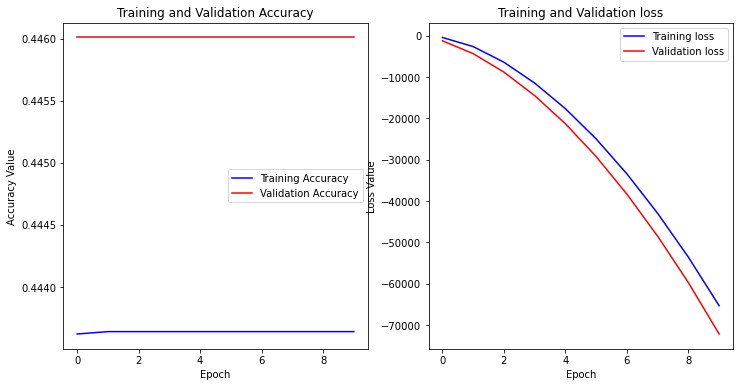

In [247]:
import matplotlib.pyplot as plt

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(acc, 'b', label='Training Accuracy')
plt.plot(val_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Training and Validation loss')
plt.legend()


# 5. SIRALI OLMAYAN MODEL OLUŞTURMA

In [248]:
################################################################
# Sıralı Olmayan Model Oluşturma

from keras.models import Model
input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(num_words, embedding_dim, embeddings_initializer=Constant(embedding_matrix), trainable=False) (input_layer)
global_layer = GlobalMaxPool1D() (embedding_layer)
dense_layer = Dense(10, activation='relu') (global_layer)
output_layer = Dense(1, activation='sigmoid') (dense_layer)

model= Model(inputs=input_layer, outputs=output_layer)

model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 52)]              0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 52, 60)            2158860   
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 60)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 10)                610       
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 11        
Total params: 2,159,481
Trainable params: 621
Non-trainable params: 2,158,860
_________________________________________________________________


In [249]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_history=model.fit(X_train ,y_train, epochs=10,  validation_data=(X_test, y_test))

Epoch 1/10
1642/1642 [==============================] - 5s 3ms/step - loss: -134.6376 - accuracy: 0.4409 - val_loss: -1111.7997 - val_accuracy: 0.4460
Epoch 2/10
1642/1642 [==============================] - 4s 3ms/step - loss: -1671.2686 - accuracy: 0.4433 - val_loss: -3778.8887 - val_accuracy: 0.4460
Epoch 3/10
1642/1642 [==============================] - 4s 3ms/step - loss: -4677.4016 - accuracy: 0.4407 - val_loss: -7609.1646 - val_accuracy: 0.4460
Epoch 4/10
1642/1642 [==============================] - 4s 2ms/step - loss: -8708.4376 - accuracy: 0.4417 - val_loss: -12494.9307 - val_accuracy: 0.4460
Epoch 5/10
1642/1642 [==============================] - 4s 3ms/step - loss: -13732.2381 - accuracy: 0.4432 - val_loss: -18378.5352 - val_accuracy: 0.4460
Epoch 6/10
1642/1642 [==============================] - 4s 2ms/step - loss: -20133.8922 - accuracy: 0.4448 - val_loss: -25217.8418 - val_accuracy: 0.4460
Epoch 7/10
1642/1642 [==============================] - 4s 3ms/step - loss: -27308.3

In [250]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))


Training Accuracy: 0.4436
Testing Accuracy: 0.4460


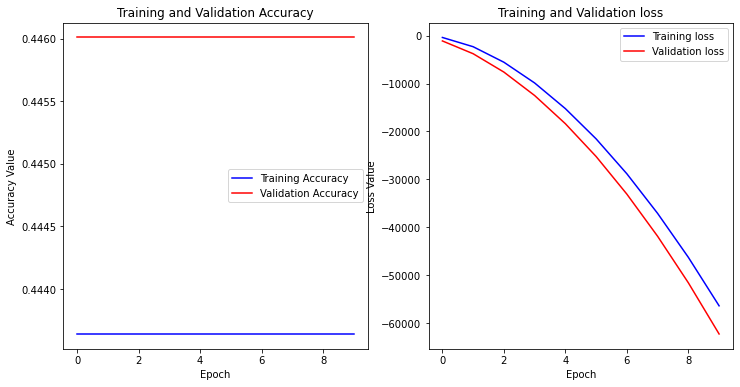

In [251]:
import matplotlib.pyplot as plt

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(acc, 'b', label='Training Accuracy')
plt.plot(val_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Training and Validation loss')
plt.legend()


# 6. OPTİMİZASYON

In [278]:
#####################################################################################################
#########################MODEL OLUŞTURMA VE EĞİTME  ###############################################

from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import Layer
from tensorflow.python.keras.layers import Dense, GRU, Embedding, CuDNNGRU, Dropout
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(df['Tweets'],  df["Duygu_Sinifi_enc"], test_size=0.3, shuffle=True)

X_test = X_test[:len(y_test)]
y_train = y_train[:len(X_train)]

# Tokenleştirme Analizi
def tokenization_tweets(dataset, features):
    tokenization = TfidfVectorizer(max_features=features)
    tokenization.fit(dataset)
    dataset_transformed = tokenization.transform(dataset).toarray()
    return dataset_transformed

def test(X_test, model_nn):
    prediction = model_nn.predict(X_test)
    return prediction

def modelDeneme1(X_train, y_train):
    features = 100
    shuffle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 6
    lr = 0.002
    epsilon = 1e-8
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(3, activation='softmax'))

    optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=0.0, amsgrad=False)
    model_nn.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])
    model_nn.fit(np.array(X_train_mod), y_train, batch_size=32, epochs=epoch, verbose=1, validation_split=validation,
                 shuffle=shuffle)
    return model_nn

modelDeneme1 = modelDeneme1(X_train, y_train)

Epoch 1/6
1478/1478 [==============================] - 8s 3ms/step - loss: 0.7664 - accuracy: 0.6670 - val_loss: 0.6527 - val_accuracy: 0.7124
Epoch 2/6
1478/1478 [==============================] - 5s 3ms/step - loss: 0.6466 - accuracy: 0.7195 - val_loss: 0.6407 - val_accuracy: 0.7202
Epoch 3/6
1478/1478 [==============================] - 5s 3ms/step - loss: 0.6335 - accuracy: 0.7285 - val_loss: 0.6284 - val_accuracy: 0.7232
Epoch 4/6
1478/1478 [==============================] - 5s 3ms/step - loss: 0.6224 - accuracy: 0.7333 - val_loss: 0.6227 - val_accuracy: 0.7287
Epoch 5/6
1478/1478 [==============================] - 5s 3ms/step - loss: 0.6013 - accuracy: 0.7447 - val_loss: 0.6052 - val_accuracy: 0.7401
Epoch 6/6
1478/1478 [==============================] - 5s 3ms/step - loss: 0.5877 - accuracy: 0.7531 - val_loss: 0.5961 - val_accuracy: 0.7460


In [289]:
#####################################################################################################
#########################MODEL OLUŞTURMA VE EĞİTME  ###############################################

from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import Layer
from tensorflow.python.keras.layers import Dense, GRU, Embedding, CuDNNGRU, Dropout
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(df['Tweets'],  df["Duygu_Sinifi_enc"], test_size=0.3, shuffle=True)

X_test = X_test[:len(y_test)]
y_train = y_train[:len(X_train)]

def modelDeneme2(X_train, y_train):
    features = 150
    shuffle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 10
    lr = 0.001
    epsilon = 1e-8
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(3, activation='softmax'))

    optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=0.0, amsgrad=False)
    model_nn.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])
    model_nn.fit(np.array(X_train_mod), y_train, batch_size=32, epochs=epoch, verbose=1, validation_split=validation,
                 shuffle=shuffle)
    return model_nn

modelDeneme2 = modelDeneme2(X_train, y_train)

Epoch 1/10
1478/1478 [==============================] - 6s 4ms/step - loss: 0.7510 - accuracy: 0.6714 - val_loss: 0.5772 - val_accuracy: 0.7691
Epoch 2/10
1478/1478 [==============================] - 6s 4ms/step - loss: 0.5912 - accuracy: 0.7528 - val_loss: 0.5654 - val_accuracy: 0.7712
Epoch 3/10
1478/1478 [==============================] - 5s 4ms/step - loss: 0.5619 - accuracy: 0.7699 - val_loss: 0.5536 - val_accuracy: 0.7765
Epoch 4/10
1478/1478 [==============================] - 6s 4ms/step - loss: 0.5509 - accuracy: 0.7754 - val_loss: 0.5469 - val_accuracy: 0.7792
Epoch 5/10
1478/1478 [==============================] - 6s 4ms/step - loss: 0.5386 - accuracy: 0.7814 - val_loss: 0.5345 - val_accuracy: 0.7866
Epoch 6/10
1478/1478 [==============================] - 6s 4ms/step - loss: 0.5189 - accuracy: 0.7948 - val_loss: 0.5277 - val_accuracy: 0.7889
Epoch 7/10
1478/1478 [==============================] - 5s 4ms/step - loss: 0.5091 - accuracy: 0.7984 - val_loss: 0.5175 - val_accuracy:

In [295]:
#####################################################################################################
#########################MODEL OLUŞTURMA VE EĞİTME  ###############################################

from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import Layer
from tensorflow.python.keras.layers import Dense, GRU, Embedding, CuDNNGRU, Dropout
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(df['Tweets'],  df["Duygu_Sinifi_enc"], test_size=0.3, shuffle=True)

X_test = X_test[:len(y_test)]
y_train = y_train[:len(X_train)]

def modelDeneme3(X_train, y_train):
    features = 250
    shuffle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 10
    lr = 0.001
    epsilon = 1e-8
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(3, activation='softmax'))

    optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=0.0, amsgrad=False)
    model_nn.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])
    model_nn.fit(np.array(X_train_mod), y_train, batch_size=32, epochs=epoch, verbose=1, validation_split=validation,
                 shuffle=shuffle)
    return model_nn

modelDeneme3 = modelDeneme3(X_train, y_train)

Epoch 1/10
1478/1478 [==============================] - 7s 4ms/step - loss: 0.7327 - accuracy: 0.6936 - val_loss: 0.5283 - val_accuracy: 0.7929
Epoch 2/10
1478/1478 [==============================] - 6s 4ms/step - loss: 0.5318 - accuracy: 0.7908 - val_loss: 0.5039 - val_accuracy: 0.7997
Epoch 3/10
1478/1478 [==============================] - 6s 4ms/step - loss: 0.5027 - accuracy: 0.8019 - val_loss: 0.4923 - val_accuracy: 0.7982
Epoch 4/10
1478/1478 [==============================] - 6s 4ms/step - loss: 0.4737 - accuracy: 0.8163 - val_loss: 0.4660 - val_accuracy: 0.8216
Epoch 5/10
1478/1478 [==============================] - 6s 4ms/step - loss: 0.4458 - accuracy: 0.8262 - val_loss: 0.4484 - val_accuracy: 0.8306
Epoch 6/10
1478/1478 [==============================] - 6s 4ms/step - loss: 0.4295 - accuracy: 0.8392 - val_loss: 0.4355 - val_accuracy: 0.8363
Epoch 7/10
1478/1478 [==============================] - 5s 4ms/step - loss: 0.4129 - accuracy: 0.8449 - val_loss: 0.4217 - val_accuracy:

In [297]:
#####################################################################################################
#########################MODEL OLUŞTURMA VE EĞİTME  ###############################################

from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import Layer
from tensorflow.python.keras.layers import Dense, GRU, Embedding, CuDNNGRU, Dropout
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(df['Tweets'],  df["Duygu_Sinifi_enc"], test_size=0.3, shuffle=True)

X_test = X_test[:len(y_test)]
y_train = y_train[:len(X_train)]

def modelDeneme4(X_train, y_train):
    features = 450
    shuffle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 10
    lr = 0.001
    epsilon = 1e-8
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(3, activation='softmax'))

    optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=0.0, amsgrad=False)
    model_nn.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])
    model_nn.fit(np.array(X_train_mod), y_train, batch_size=32, epochs=epoch, verbose=1, validation_split=validation,
                 shuffle=shuffle)
    return model_nn

modelDeneme4 = modelDeneme4(X_train, y_train)

Epoch 1/10
1478/1478 [==============================] - 8s 5ms/step - loss: 0.6986 - accuracy: 0.7011 - val_loss: 0.4553 - val_accuracy: 0.8283
Epoch 2/10
1478/1478 [==============================] - 8s 5ms/step - loss: 0.4492 - accuracy: 0.8277 - val_loss: 0.4340 - val_accuracy: 0.8350
Epoch 3/10
1478/1478 [==============================] - 8s 6ms/step - loss: 0.4089 - accuracy: 0.8438 - val_loss: 0.4101 - val_accuracy: 0.8454
Epoch 4/10
1478/1478 [==============================] - 8s 5ms/step - loss: 0.3716 - accuracy: 0.8592 - val_loss: 0.3905 - val_accuracy: 0.8580
Epoch 5/10
1478/1478 [==============================] - 8s 5ms/step - loss: 0.3358 - accuracy: 0.8756 - val_loss: 0.3691 - val_accuracy: 0.8719
Epoch 6/10
1478/1478 [==============================] - 8s 5ms/step - loss: 0.3006 - accuracy: 0.8908 - val_loss: 0.3546 - val_accuracy: 0.8755
Epoch 7/10
1478/1478 [==============================] - 8s 5ms/step - loss: 0.2698 - accuracy: 0.9043 - val_loss: 0.3395 - val_accuracy:

In [301]:
#####################################################################################################
#########################MODEL OLUŞTURMA VE EĞİTME  ###############################################

from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import Layer
from tensorflow.python.keras.layers import Dense, GRU, Embedding, CuDNNGRU, Dropout
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(df['Tweets'],  df["Duygu_Sinifi_enc"], test_size=0.3, shuffle=True)

X_test = X_test[:len(y_test)]
y_train = y_train[:len(X_train)]

def modelDeneme4(X_train, y_train):
    features = 1000
    shuffle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 10
    lr = 0.001
    epsilon = 1e-8
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(3, activation='softmax'))

    optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=0.0, amsgrad=False)
    model_nn.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])
    model_nn.fit(np.array(X_train_mod), y_train, batch_size=32, epochs=epoch, verbose=1, validation_split=validation,
                 shuffle=shuffle)
    return model_nn

modelDeneme4 = modelDeneme4(X_train, y_train)

Epoch 1/10
1478/1478 [==============================] - 12s 8ms/step - loss: 0.6482 - accuracy: 0.7234 - val_loss: 0.3337 - val_accuracy: 0.8919
Epoch 2/10
1478/1478 [==============================] - 11s 8ms/step - loss: 0.3243 - accuracy: 0.8906 - val_loss: 0.3016 - val_accuracy: 0.9037
Epoch 3/10
1478/1478 [==============================] - 11s 7ms/step - loss: 0.2709 - accuracy: 0.9066 - val_loss: 0.2663 - val_accuracy: 0.9140
Epoch 4/10
1478/1478 [==============================] - 11s 8ms/step - loss: 0.2179 - accuracy: 0.9280 - val_loss: 0.2420 - val_accuracy: 0.9267
Epoch 5/10
1478/1478 [==============================] - 11s 7ms/step - loss: 0.1696 - accuracy: 0.9457 - val_loss: 0.2310 - val_accuracy: 0.9307
Epoch 6/10
1478/1478 [==============================] - 11s 7ms/step - loss: 0.1283 - accuracy: 0.9591 - val_loss: 0.2070 - val_accuracy: 0.9425
Epoch 7/10
1478/1478 [==============================] - 11s 8ms/step - loss: 0.1055 - accuracy: 0.9680 - val_loss: 0.2039 - val_ac

In [302]:
#####################################################################################################
#########################MODEL OLUŞTURMA VE EĞİTME  ###############################################

from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import Layer
from tensorflow.python.keras.layers import Dense, GRU, Embedding, CuDNNGRU, Dropout
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(df['Tweets'],  df["Duygu_Sinifi_enc"], test_size=0.3, shuffle=True)

X_test = X_test[:len(y_test)]
y_train = y_train[:len(X_train)]

def modelDeneme5(X_train, y_train):
    features = 5000
    shuffle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 10
    lr = 0.001
    epsilon = 1e-8
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(3, activation='softmax'))

    optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=0.0, amsgrad=False)
    model_nn.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])
    model_nn.fit(np.array(X_train_mod), y_train, batch_size=32, epochs=epoch, verbose=1, validation_split=validation,
                 shuffle=shuffle)
    return model_nn

modelDeneme5 = modelDeneme5(X_train, y_train)

Epoch 1/10
1478/1478 [==============================] - 43s 22ms/step - loss: 0.6029 - accuracy: 0.7411 - val_loss: 0.1738 - val_accuracy: 0.9433
Epoch 2/10
1478/1478 [==============================] - 32s 22ms/step - loss: 0.1259 - accuracy: 0.9617 - val_loss: 0.1315 - val_accuracy: 0.9617
Epoch 3/10
1478/1478 [==============================] - 32s 22ms/step - loss: 0.0731 - accuracy: 0.9797 - val_loss: 0.1198 - val_accuracy: 0.9682
Epoch 4/10
1478/1478 [==============================] - 30s 20ms/step - loss: 0.0436 - accuracy: 0.9886 - val_loss: 0.1257 - val_accuracy: 0.9686
Epoch 5/10
1478/1478 [==============================] - 31s 21ms/step - loss: 0.0263 - accuracy: 0.9935 - val_loss: 0.1369 - val_accuracy: 0.9718
Epoch 6/10
1478/1478 [==============================] - 31s 21ms/step - loss: 0.0181 - accuracy: 0.9956 - val_loss: 0.1500 - val_accuracy: 0.9711
Epoch 7/10
1478/1478 [==============================] - 33s 22ms/step - loss: 0.0124 - accuracy: 0.9967 - val_loss: 0.1491 -

# 7. MODEL TEST ETME

In [328]:
new_df = df[30000:]


In [327]:
new_df

,index,Tweets,Polarity,Subjectivity,Duygu_Sinifi,Duygu_Sinifi_enc
30000,40354,student awareness towards elearning study diff...,0.000000,0.600000,Notr,1
30001,40355,elearning course popular put together frequent...,0.350000,0.600000,Pozitif,2
30002,40356,team working clinically due covid pressure als...,-0.162500,0.387500,Negatif,0
30003,40357,elearning kenyan,0.000000,0.000000,Notr,1
30004,40358,download app want become tech expe learn nextg...,0.000000,0.000000,Notr,1
...,...,...,...,...,...,...
75037,99994,student take elearning bark,0.000000,0.000000,Notr,1
75038,99995,xiaomi launch affordable mi notebook elearning...,0.000000,0.000000,Notr,1
75039,99996,want free place globally recognised safety hea...,0.200000,0.400000,Pozitif,2
75040,99997,social distancing requirement caused people sp...,-0.016667,0.316667,Negatif,0


In [329]:
X_train, X_test, y_train, y_test = train_test_split(new_df['Tweets'],  new_df["Duygu_Sinifi_enc"], test_size=0.3, shuffle=True)

X_test = X_test[:len(y_test)]
y_train = y_train[:len(X_train)]


In [331]:
#####################################################################################################
#########################MODEL OLUŞTURMA VE EĞİTME  ###############################################

from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import Layer
from tensorflow.python.keras.layers import Dense, GRU, Embedding, CuDNNGRU, Dropout
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(new_df['Tweets'],  new_df["Duygu_Sinifi_enc"], test_size=0.3, shuffle=True)

X_test = X_test[:len(y_test)]
y_train = y_train[:len(X_train)]

def modelDeneme5(X_train, y_train):
    features = 5000
    shuffle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 10
    lr = 0.001
    epsilon = 1e-8
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(3, activation='softmax'))

    optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=0.0, amsgrad=False)
    model_nn.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])
    model_nn.fit(np.array(X_train_mod), y_train, batch_size=32, epochs=epoch, verbose=1, validation_split=validation,
                 shuffle=shuffle)
    return model_nn

modelDeneme5 = modelDeneme5(X_train, y_train)

Epoch 1/10
887/887 [==============================] - 31s 22ms/step - loss: 0.6946 - accuracy: 0.6931 - val_loss: 0.2517 - val_accuracy: 0.9141
Epoch 2/10
887/887 [==============================] - 20s 22ms/step - loss: 0.1754 - accuracy: 0.9442 - val_loss: 0.2142 - val_accuracy: 0.9315
Epoch 3/10
887/887 [==============================] - 20s 23ms/step - loss: 0.0994 - accuracy: 0.9701 - val_loss: 0.2295 - val_accuracy: 0.9315
Epoch 4/10
887/887 [==============================] - 19s 22ms/step - loss: 0.0620 - accuracy: 0.9825 - val_loss: 0.2401 - val_accuracy: 0.9397
Epoch 5/10
887/887 [==============================] - 20s 22ms/step - loss: 0.0373 - accuracy: 0.9899 - val_loss: 0.2736 - val_accuracy: 0.9343
Epoch 6/10
887/887 [==============================] - 20s 22ms/step - loss: 0.0246 - accuracy: 0.9934 - val_loss: 0.3110 - val_accuracy: 0.9350
Epoch 7/10
887/887 [==============================] - 18s 20ms/step - loss: 0.0161 - accuracy: 0.9963 - val_loss: 0.3292 - val_accuracy:

In [337]:
control_data = tokenization_tweets(new_df['Tweets'], 5000)
control_data_pred = modelDeneme5.predict(control_data)

In [342]:
control_data_pred

array([[4.6568150e-08, 1.0000000e+00, 9.1667873e-09],
       [2.9361482e-08, 9.9997330e-01, 2.6668480e-05],
       [1.2053777e-10, 1.2247720e-08, 1.0000000e+00],
       ...,
       [5.3274598e-05, 2.6038243e-02, 9.7390848e-01],
       [9.6958601e-01, 3.7593886e-04, 3.0038055e-02],
       [7.9746070e-07, 7.4598356e-04, 9.9925321e-01]], dtype=float32)

# 8. RESULT

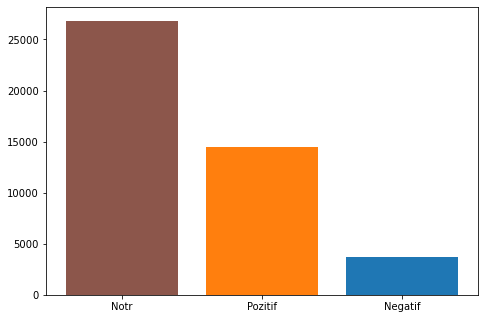

In [354]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
notr_count = 0
positive_count = 0
negative_count = 0

for pred in control_data_pred:
    duygu_enc = np.argmax(pred)
    #print(duygu_enc)

    if  duygu_enc == 0:
        negative_count +=1
        ax.bar('Negatif', negative_count)
    elif duygu_enc == 1:
        notr_count +=1
        ax.bar('Notr', notr_count)
    elif duygu_enc == 2:
        positive_count+=1
        ax.bar('Pozitif', positive_count)

plt.show()
